In [8]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from mylib.envs.blackjack import BlackjackEnv
from mylib import plotting

matplotlib.style.use('ggplot')

In [9]:
env = BlackjackEnv()

In [10]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [11]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1
        
    return policy_fn

In [12]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The cumulative denominator of the weighted importance sampling formula
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # Implement this!
    for i_ep in range(1, num_episodes+1):
        #print out which eps we are in 
        if i_ep%1000 == 0 :
            print("\rEpisode : {}/{}.".format(i_ep, num_episodes), end = "") #output fornat as solution
            sys.stdout.flush() # to ensure out put @ the episode
        #generate episode with behavior policy
        episode = []
        state = env.reset()
        for t in range(100):
            policy = behavior_policy(state)
            action = np.random.choice(len(policy), p=policy)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        #eval q-value with target policy
        G = 0;
        W = 1.0;
        for k in range(len(episode))[::-1]:
            state, action, reward = episode[k]
            G = discount_factor * G + reward
            C[state][action] += W
            Q[state][action] += (W/C[state][action])*(G-Q[state][action])
            
            #here comes the part that i dont quite understand now
            if action !=  np.argmax(target_policy(state)): #no need to update suboptimal value ?
                break
            W = W * 1./behavior_policy(state)[action] #why this value instead of the one in ord. importance sampling 
        
        
        
    return Q, target_policy

In [13]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode : 500000/500000.

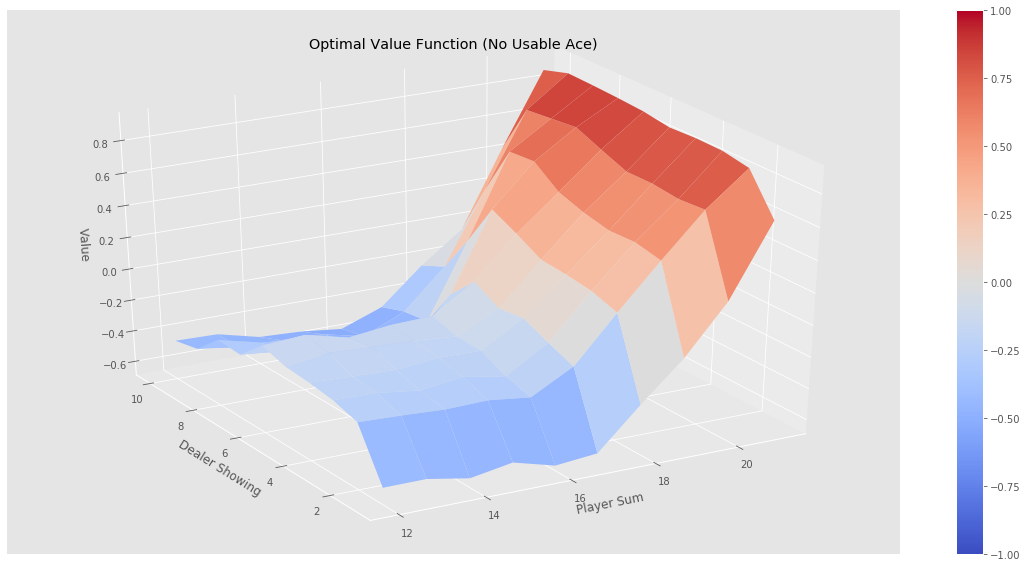

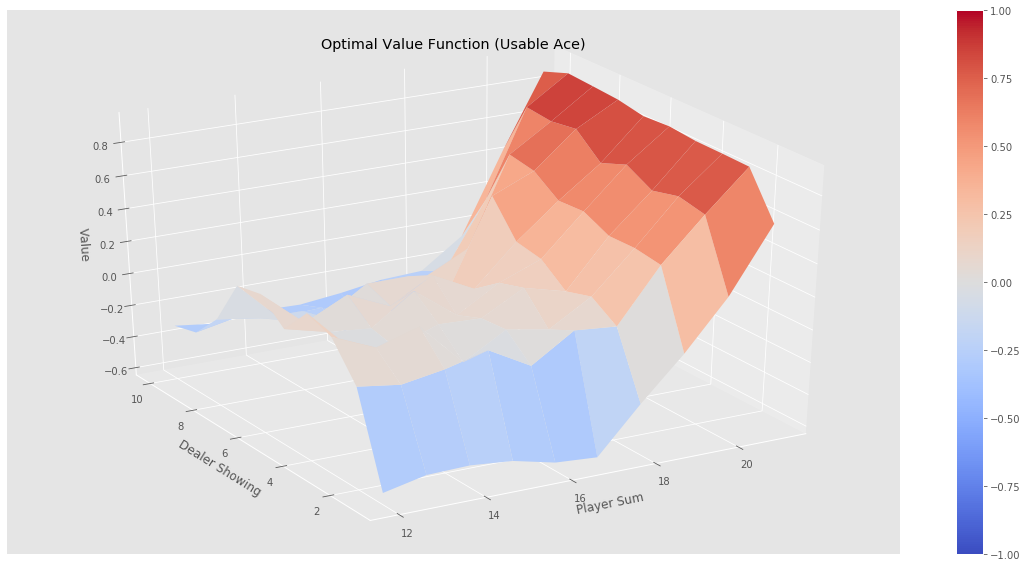

In [14]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")